Evaluation (for GloVe-CNN)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

In [2]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions


SAVE_EVAL_RESULTS = True
SAVE_NUMPY_ARRAYS = True
LOAD_NUMPY_ARRAYS = False

In [3]:
# import importlib
# importlib.reload(evaluation_functions)

In [177]:
DATASET_SIZE = 120
DATASET_IS_BALANCED = False


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_args_datetime = datetime(year=2024, month=2, day=26)
training_name = 'glove-cnn-{}_{}k_{}_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal',
    training_args_datetime.strftime('%Y-%m-%d')
)

training_storing_folder = Path(training_name).resolve()

In [178]:
# rerun this cell if want to evaluate a new model

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 120k, is_balanced: False

Training dataset class distribution
review_score
1    89949
0    18051
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    10051
0     1949
Name: count, dtype: int64





In [6]:
# load validation dataset. Same for all models

X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_validation_dataset()

Loaded validation dataset

Validation dataset imbalanced class distribution
review_score
1    656654
0    134001
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
1    134294
0    134294
Name: count, dtype: int64





In [9]:
# data cleaning function
# same as training script

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_links2(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_non_letters(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))      # no need to remove stopwords, as glove is trained with stopwords
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))


    return str_arr

In [179]:
# rerun this cell if want to evaluate a new model

X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

In [11]:
# applying data cleaning to all datasets
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

# X_bal_valid = X_bal_valid.to_numpy()
# y_bal_valid = y_bal_valid.to_numpy()

# X_imbal_valid = X_imbal_valid.to_numpy()
# y_imbal_valid = y_imbal_valid.to_numpy()

In [180]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
790655
790655

Validation (balanced) set
268588
268588


Validation (imbalanced) set
review_score
1    656654
0    134001
Name: count, dtype: int64

Validation (balanced) set
review_score
1    134294
0    134294
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Load the models

Load the text vectorizer, model itself

Then transform the data through the vectorizer

In [181]:
import pickle

import tensorflow as tf
import keras

text_vectorizer_path = Path.joinpath(training_storing_folder, "{}_textvectorizer.pkl".format(
    training_name,
))
vectorizer_from_disk = pickle.load(open(text_vectorizer_path, 'rb'))
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=512)

vectorizer.set_weights(vectorizer_from_disk['weights'])

model_path = Path.joinpath(training_storing_folder, "{}_model.keras".format(
    training_name
))
model = keras.models.load_model(model_path)

print('\n\n')
print('Loaded text vectorizer from {}'.format(text_vectorizer_path))
print('Loaded model from {}'.format(model_path))




Loaded text vectorizer from /root/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_120k_imbal_2024-02-26/glove-cnn-20000_120k_imbal_2024-02-26_textvectorizer.pkl
Loaded model from /root/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_120k_imbal_2024-02-26/glove-cnn-20000_120k_imbal_2024-02-26_model.keras


In [182]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 512, 300)             6000600   ['input_7[0][0]']             
                                                                                                  
 conv1d_9 (Conv1D)           (None, 506, 128)             268928    ['embedding_3[0][0]']         
                                                                                                  
 conv1d_10 (Conv1D)          (None, 506, 128)             268928    ['embedding_3[0][0]']         
                                                                                            

In [183]:
# create keras dataset object for evaluation
# same as training script

BATCH_SIZE = 128

import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_bal_dataset = tf.data.Dataset.from_tensor_slices((X_bal_valid, y_bal_valid))
valid_imbal_dataset = tf.data.Dataset.from_tensor_slices((X_imbal_valid, y_imbal_valid))

In [184]:
# batch first

test_dataset = test_dataset.batch(BATCH_SIZE)
valid_bal_dataset = valid_bal_dataset.batch(BATCH_SIZE)
valid_imbal_dataset = valid_imbal_dataset.batch(BATCH_SIZE)

In [185]:
# apply text vectorizer to test and validation datasets

test_dataset = test_dataset.map(lambda x, y: (vectorizer(x), y))
valid_bal_dataset = valid_bal_dataset.map(lambda x, y: (vectorizer(x), y))
valid_imbal_dataset = valid_imbal_dataset.map(lambda x, y: (vectorizer(x), y))

In [186]:
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
valid_bal_dataset = valid_bal_dataset.prefetch(tf.data.AUTOTUNE)
valid_imbal_dataset = valid_imbal_dataset.prefetch(tf.data.AUTOTUNE)

---

Evaluation

on test set

In [187]:
# create folders for storing evaluation metrics

eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

In [188]:
if LOAD_NUMPY_ARRAYS:
    y_test_pred_prob_raw = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'))
    y_test_pred = np.load(Path.joinpath(eval_test_folder, 'y_test_pred.npy'))
    y_test_pred_prob = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'))
    y_test = np.load(Path.joinpath(eval_test_folder, 'y_test.npy'))
else:
    y_test_pred_prob_raw = model.predict(test_dataset)

    y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

    y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                    else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

94/94 [==============================] - 1s 7ms/step


In [189]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'), y_test_pred_prob_raw)
    np.save(Path.joinpath(eval_test_folder, 'y_pred.npy'), y_test_pred)
    np.save(Path.joinpath(eval_test_folder, 'y_pred_prob.npy'), y_test_pred_prob)
    np.save(Path.joinpath(eval_test_folder, 'y_test.npy'), y_test)

In [190]:
test_classification_report_dict = evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.68      0.71      1949
           1       0.94      0.95      0.95     10051

    accuracy                           0.91     12000
   macro avg       0.84      0.82      0.83     12000
weighted avg       0.91      0.91      0.91     12000



TN - True Negative 1331
FN - False Negative 472
TP - True Positive 9579
FP - False Positive 618
Accuracy Rate: 0.9091666666666667
Misclassification Rate: 0.09083333333333334
F1-Score: 0.8278278978197009
ROC-AUC 0.817976906795354


In [191]:
test_classification_report_dict

{'0': {'precision': 0.7382140876317249,
  'recall': 0.6829143150333504,
  'f1-score': 0.7094882729211086,
  'support': 1949.0},
 '1': {'precision': 0.9393939393939394,
  'recall': 0.9530394985573575,
  'f1-score': 0.9461675227182931,
  'support': 10051.0},
 'accuracy': 0.9091666666666667,
 'macro avg': {'precision': 0.8388040135128322,
  'recall': 0.817976906795354,
  'f1-score': 0.8278278978197009,
  'support': 12000.0},
 'weighted avg': {'precision': 0.9067189784702265,
  'recall': 0.9091666666666667,
  'f1-score': 0.907726867897067,
  'support': 12000.0}}

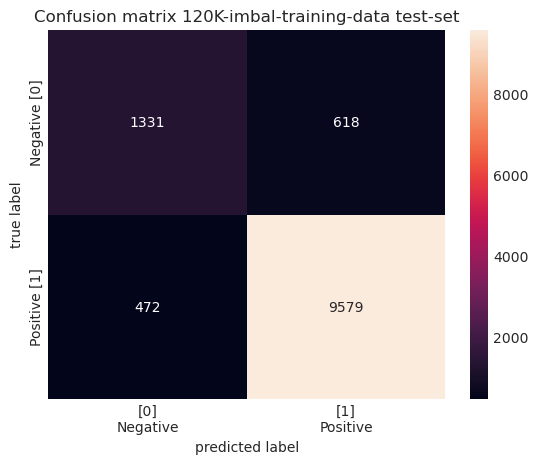

In [192]:
import matplotlib as plt
plt.style.use('seaborn-v0_8-dark')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'confusion_matrix_test.png'),
    show=True
)

In [193]:
y_test, y_test_pred_prob

(3146613    1
 1031977    1
 2115616    1
 3845525    1
 3491105    1
           ..
 3221387    1
 2429713    0
 176186     0
 3817244    1
 2601338    1
 Name: review_score, Length: 12000, dtype: int64,
 array([0.99228257, 0.9942064 , 0.9978902 , ..., 0.5925167 , 0.9880251 ,
        0.98325783], dtype=float32))

0.7289142459143336


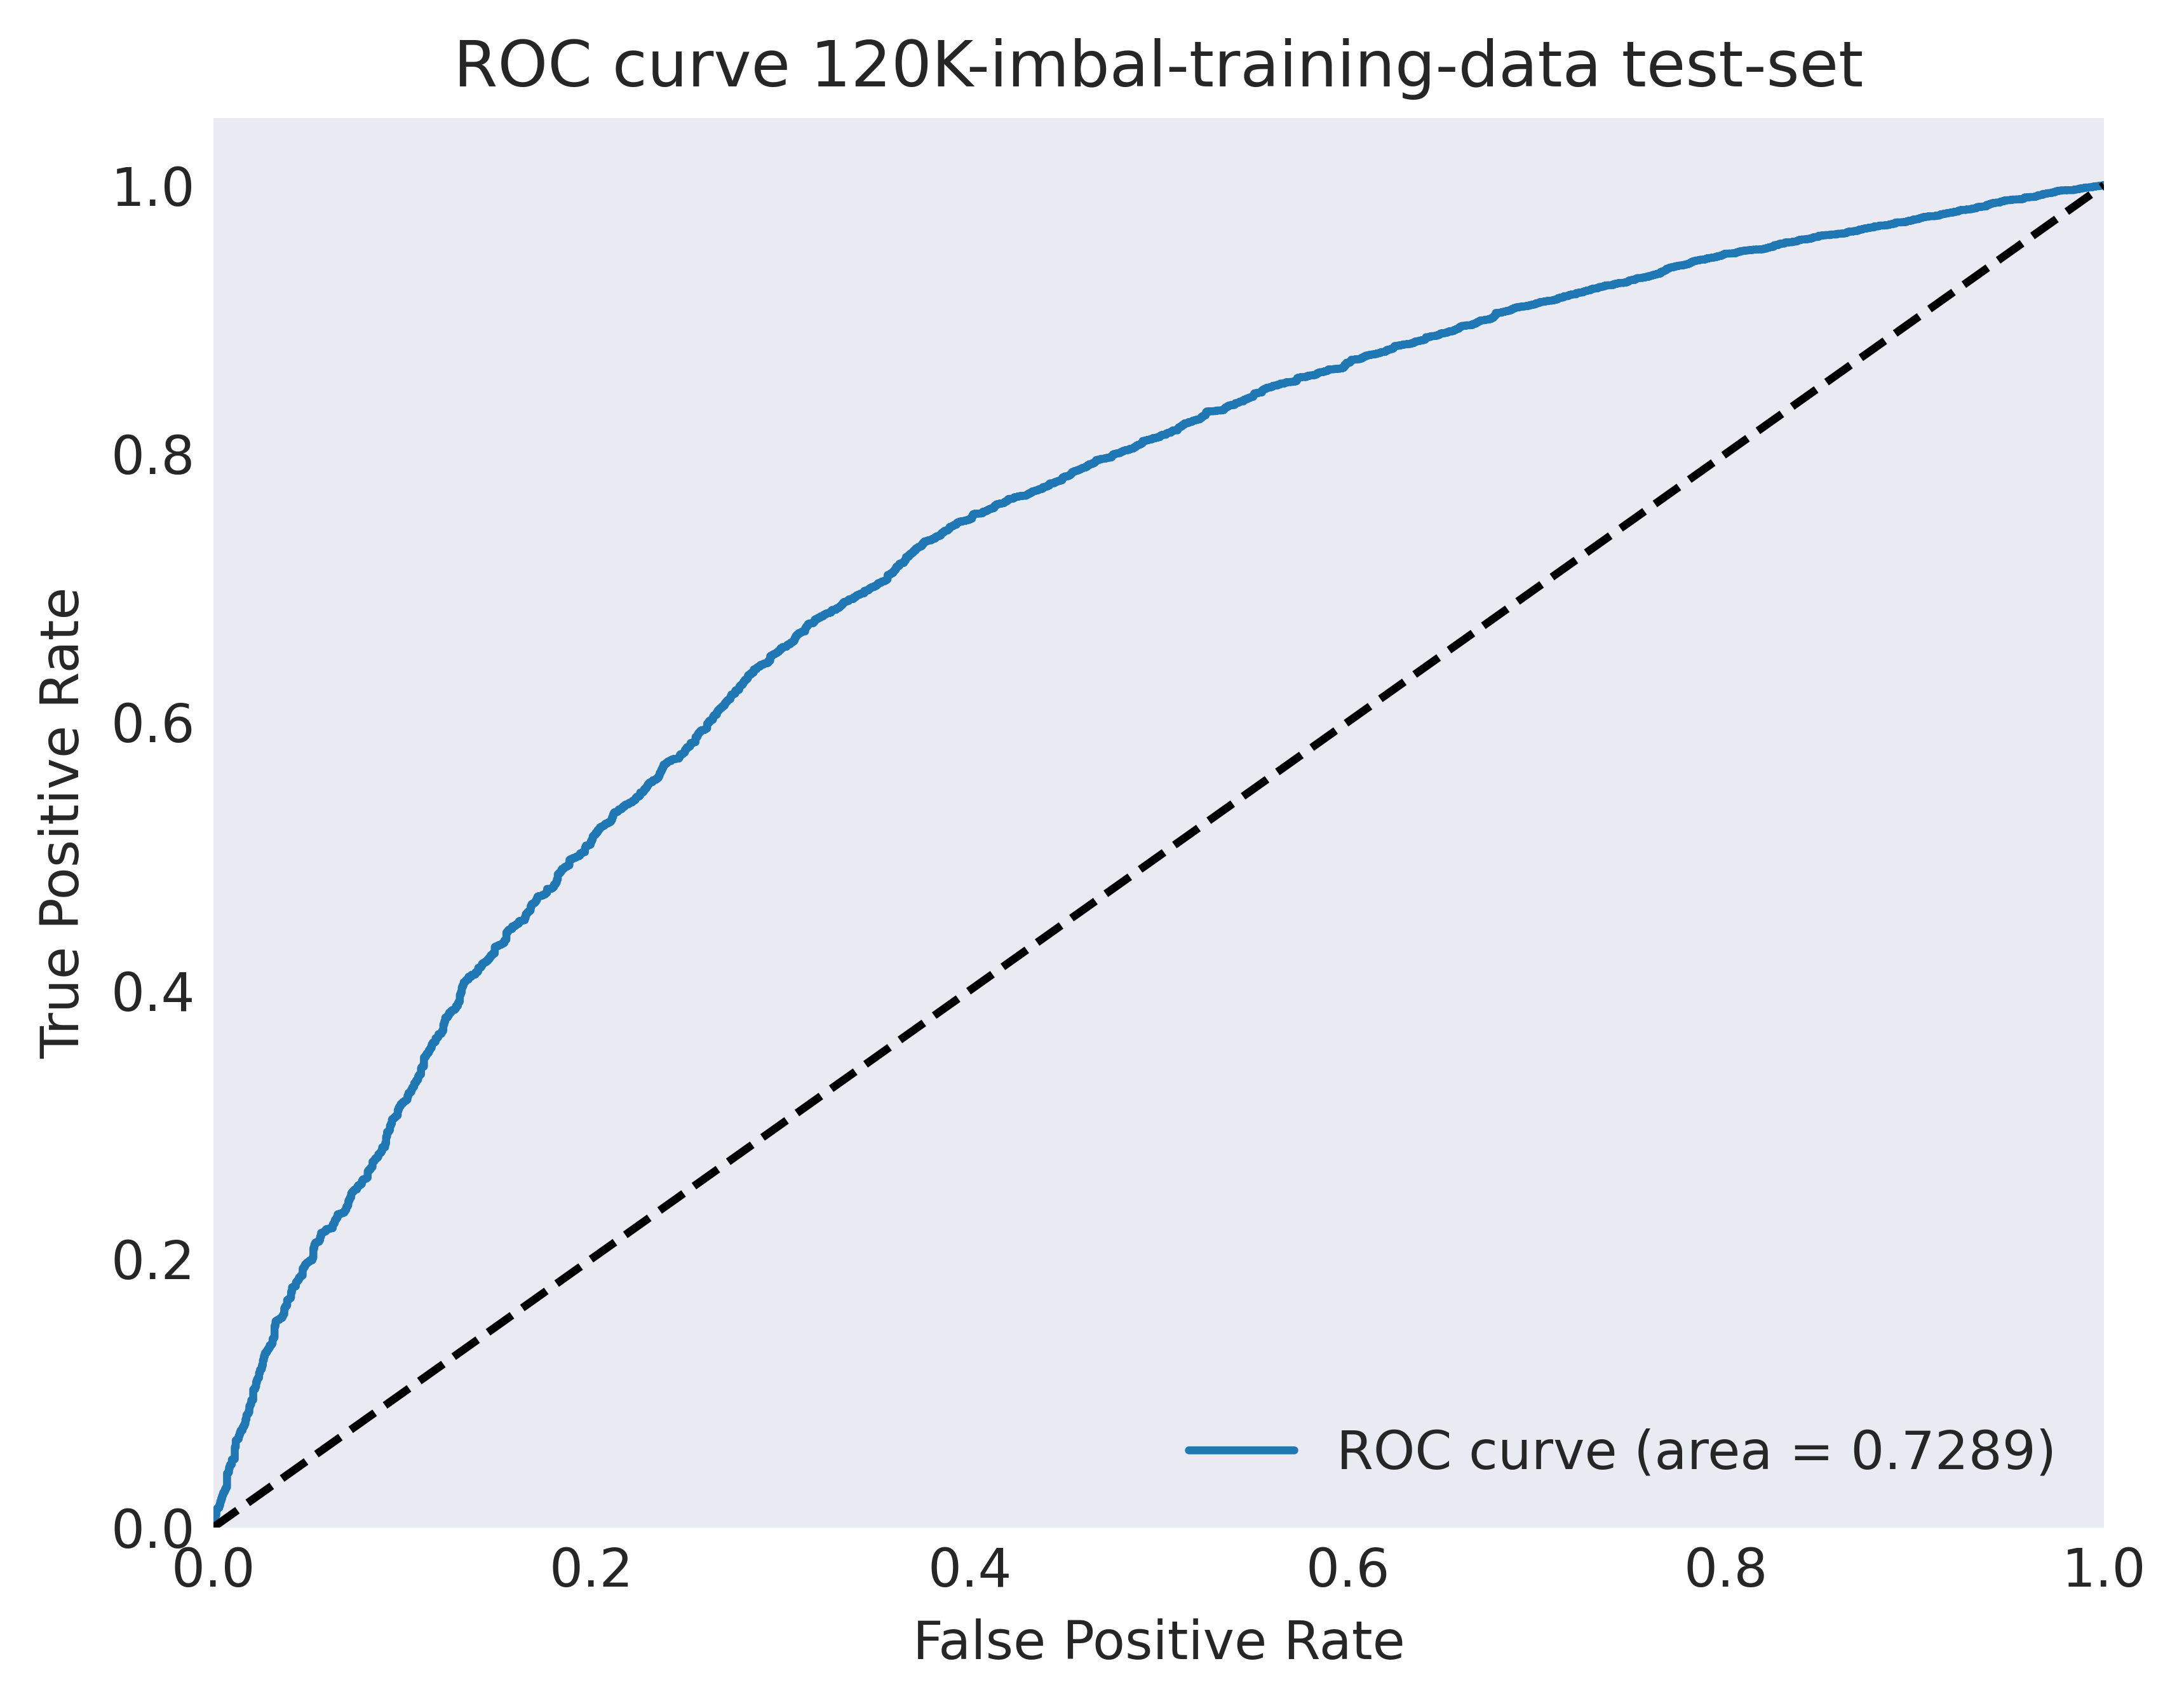

In [194]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'roc_curve_test.png'),
    show=True
)

In [195]:
from sklearn.metrics import roc_auc_score

# import importlib
# importlib.reload(evaluation_functions)

# add ROC area to report_dict
test_classification_report_dict['roc_auc'] = roc_auc_score(y_test, y_test_pred_prob)

test_report_df = evaluation_functions.create_classification_report_df(
    test_classification_report_dict, 
    training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    test_report_df.to_csv(Path.joinpath(eval_test_folder, "{}_{}_test_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed balanced validation set

In [196]:
if LOAD_NUMPY_ARRAYS:
    y_bal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred_prob_raw.npy'))
    y_bal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred.npy'))
    y_bal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid_pred_prob.npy'))
    y_bal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_bal_valid.npy'))
else:
    y_bal_valid_pred_prob_raw = model.predict(valid_bal_dataset)

    y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

    y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                    else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

 397/2099 [====>.........................] - ETA: 7s

2099/2099 [==============================] - 9s 4ms/step


In [197]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'), y_bal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'), y_bal_valid_pred)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'), y_bal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'), y_bal_valid)

In [198]:
bal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.68      0.79    134294
           1       0.75      0.96      0.84    134294

    accuracy                           0.82    268588
   macro avg       0.85      0.82      0.82    268588
weighted avg       0.85      0.82      0.82    268588



TN - True Negative 91636
FN - False Negative 5858
TP - True Positive 128436
FP - False Positive 42658
Accuracy Rate: 0.8193664646223956
Misclassification Rate: 0.18063353537760435
F1-Score: 0.8159106447037716
ROC-AUC 0.8193664646223956


In [199]:
bal_valid_classification_result_dict

{'0': {'precision': 0.9399142511334031,
  'recall': 0.6823536420093228,
  'f1-score': 0.7906880425216145,
  'support': 134294.0},
 '1': {'precision': 0.7506750675067507,
  'recall': 0.9563792872354685,
  'f1-score': 0.8411332468859288,
  'support': 134294.0},
 'accuracy': 0.8193664646223956,
 'macro avg': {'precision': 0.845294659320077,
  'recall': 0.8193664646223957,
  'f1-score': 0.8159106447037716,
  'support': 268588.0},
 'weighted avg': {'precision': 0.845294659320077,
  'recall': 0.8193664646223956,
  'f1-score': 0.8159106447037717,
  'support': 268588.0}}

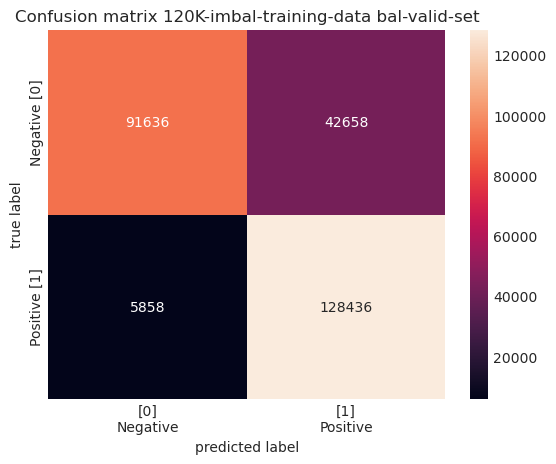

In [200]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'confusion_matrix_valid_bal.png'),
    show=True
)

0.7369938925658749


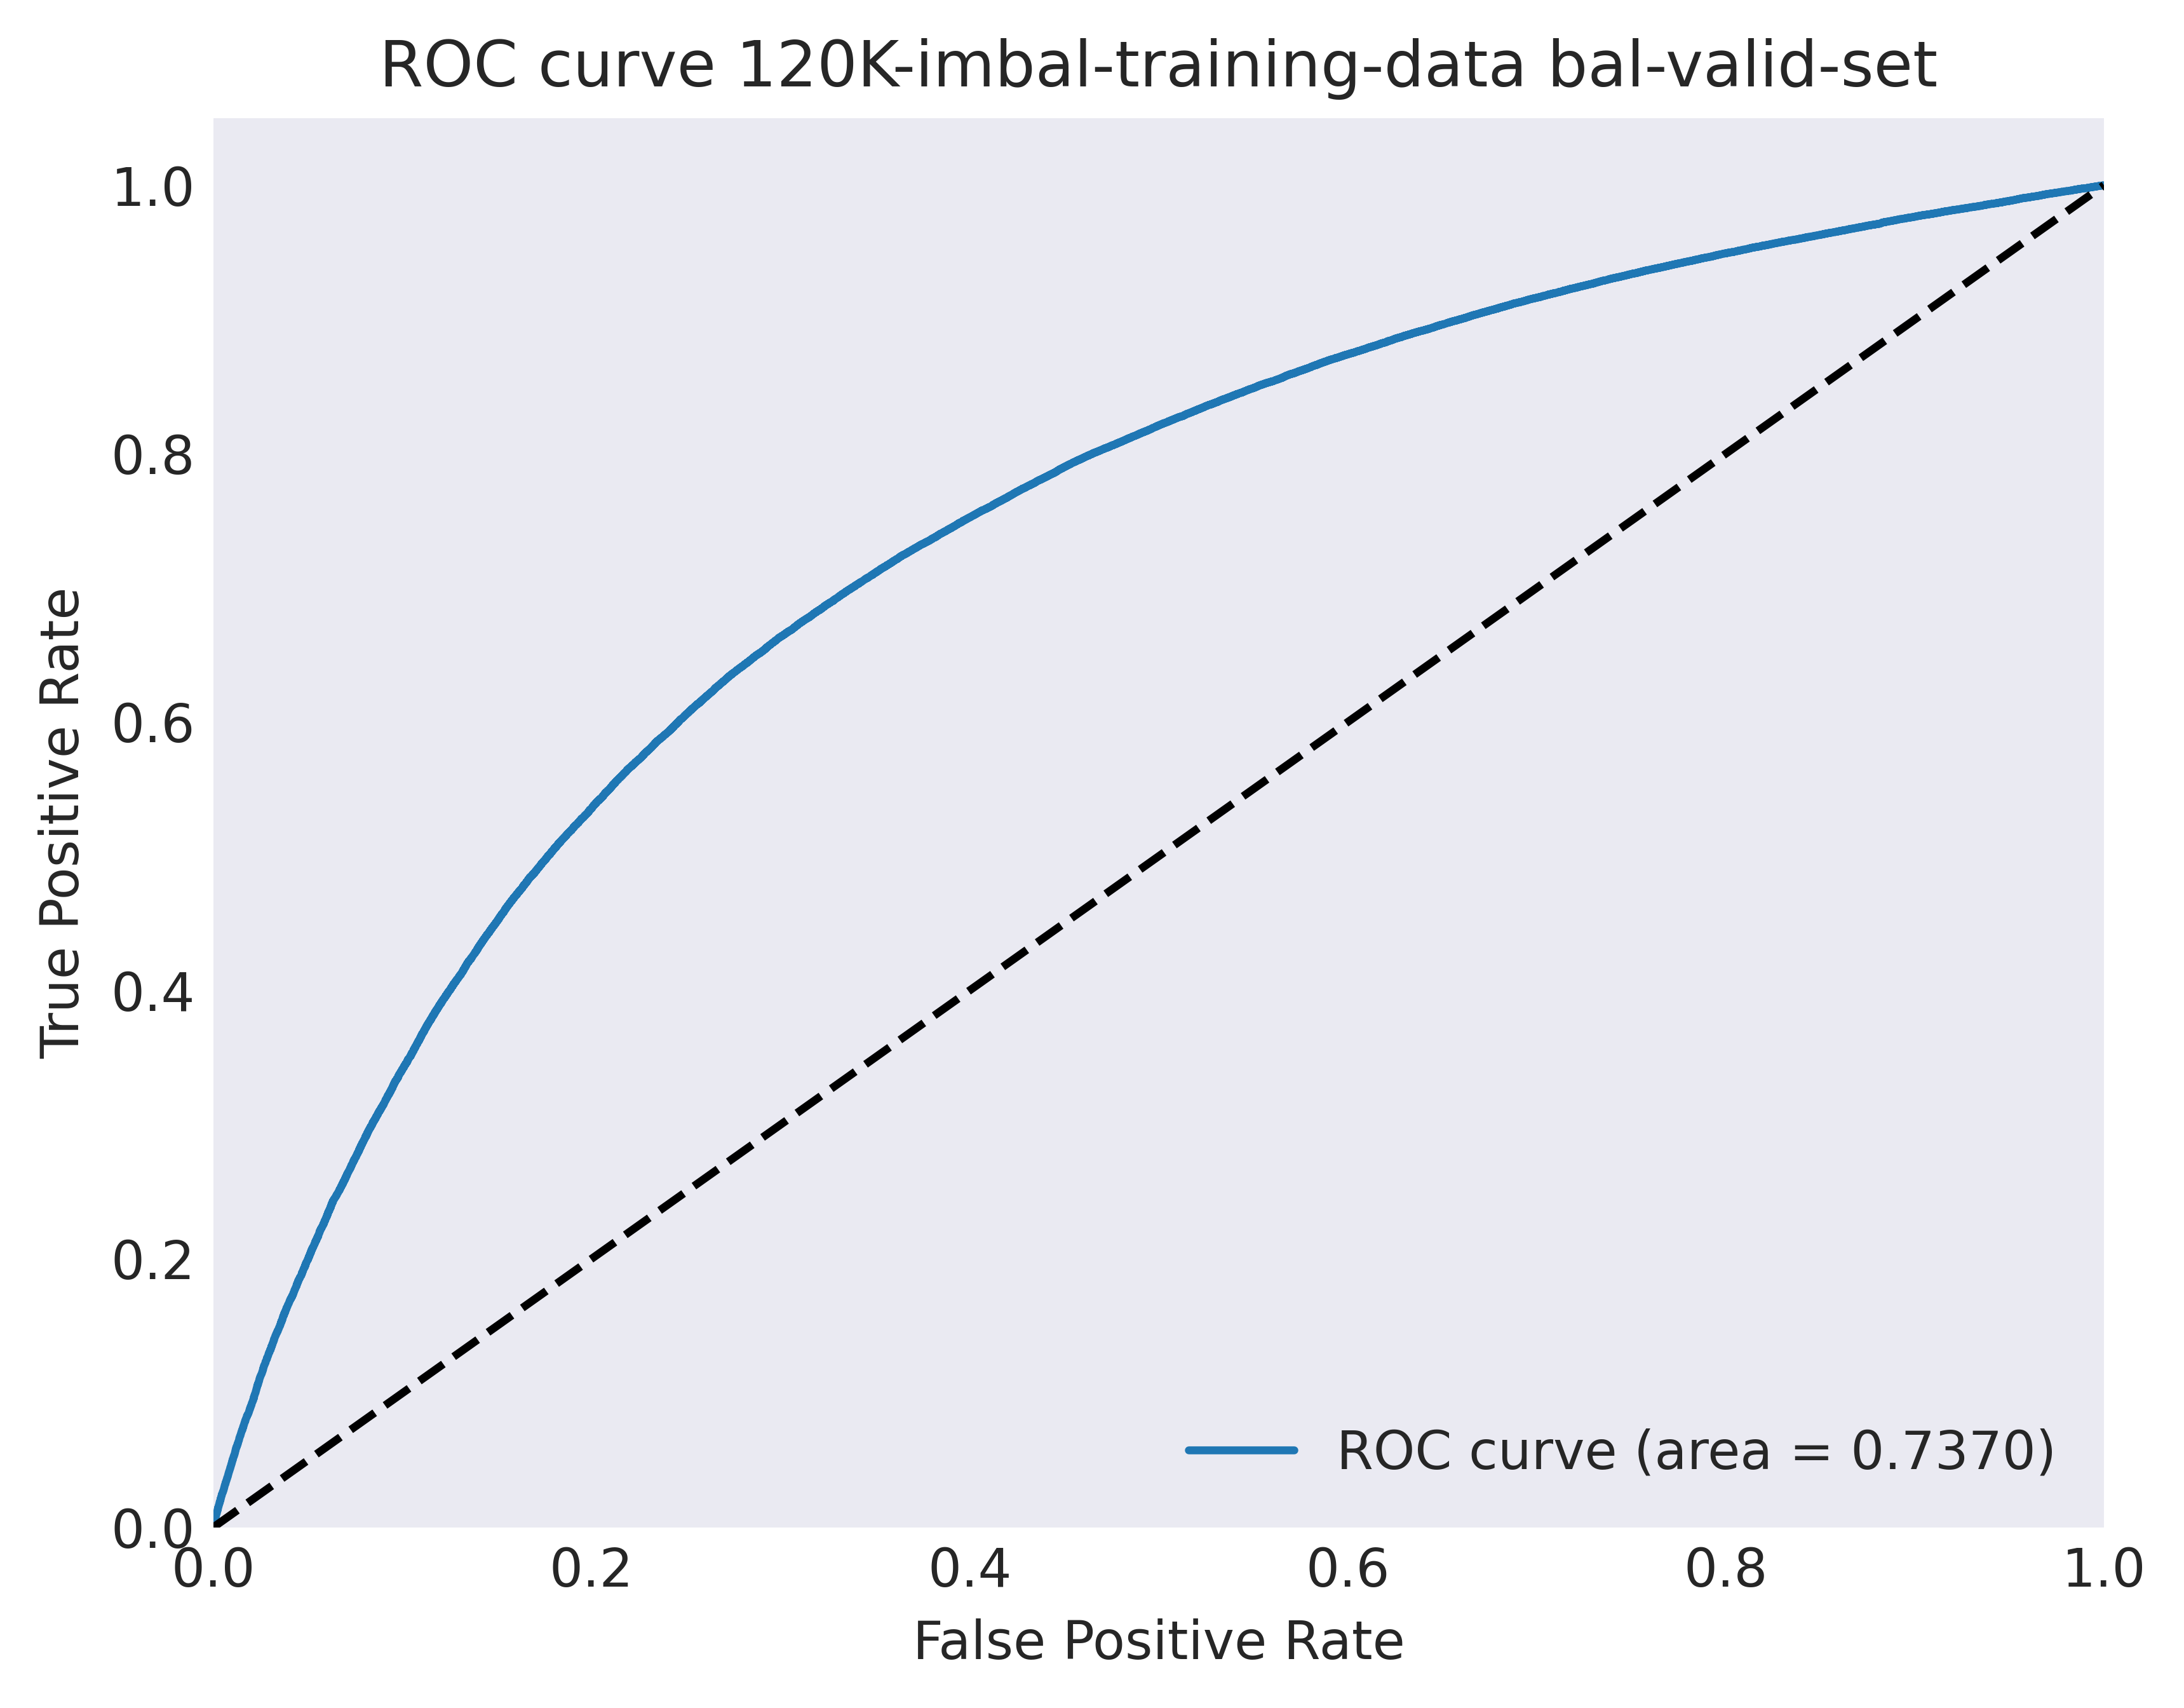

In [201]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'roc_curve_valid_bal.png'),
    show=True
)

In [202]:
# add ROC area to report_dict
bal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_bal_valid, y_bal_valid_pred_prob)

bal_valid_report_df = evaluation_functions.create_classification_report_df(bal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    bal_valid_report_df.to_csv(Path.joinpath(eval_valid_bal_folder, "{}_{}_valid_bal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed validation set (imbalanced)

In [203]:
if LOAD_NUMPY_ARRAYS:
    y_imbal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'))
    y_imbal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'))
    y_imbal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'))
    y_imbal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'))

else:
    y_imbal_valid_pred_prob_raw = model.predict(valid_imbal_dataset)

    y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

    y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                    else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

  23/6177 [..............................] - ETA: 1:03

6177/6177 [==============================] - 28s 5ms/step


In [204]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'), y_imbal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'), y_imbal_valid_pred)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'), y_imbal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'), y_imbal_valid)

In [205]:
imbal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.69      0.72    134001
           1       0.94      0.96      0.95    656654

    accuracy                           0.91    790655
   macro avg       0.85      0.82      0.84    790655
weighted avg       0.91      0.91      0.91    790655



TN - True Negative 91883
FN - False Negative 28243
TP - True Positive 628411
FP - False Positive 42118
Accuracy Rate: 0.9110092265273729
Misclassification Rate: 0.08899077347262713
F1-Score: 0.8350556646777506
ROC-AUC 0.8213392192277951


In [206]:
imbal_valid_classification_result_dict

{'0': {'precision': 0.7648885337062751,
  'recall': 0.6856889127693077,
  'f1-score': 0.7231266256635461,
  'support': 134001.0},
 '1': {'precision': 0.9371869076505267,
  'recall': 0.9569895256862823,
  'f1-score': 0.9469847036919551,
  'support': 656654.0},
 'accuracy': 0.9110092265273729,
 'macro avg': {'precision': 0.8510377206784009,
  'recall': 0.821339219227795,
  'f1-score': 0.8350556646777506,
  'support': 790655.0},
 'weighted avg': {'precision': 0.9079856069480665,
  'recall': 0.9110092265273729,
  'f1-score': 0.9090450127851945,
  'support': 790655.0}}

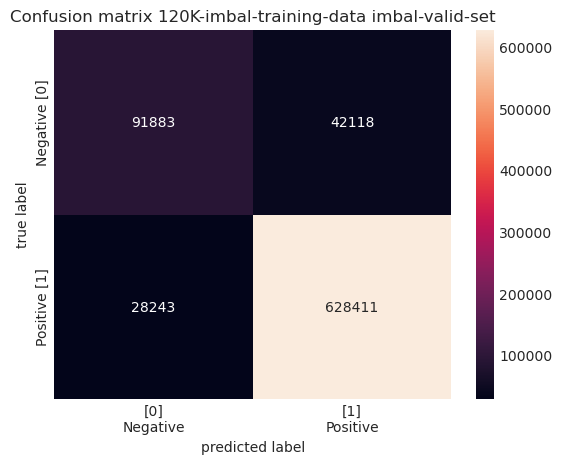

In [207]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'confusion_matrix_valid_imbal.png'),
    show=True
)

0.7352026162323113


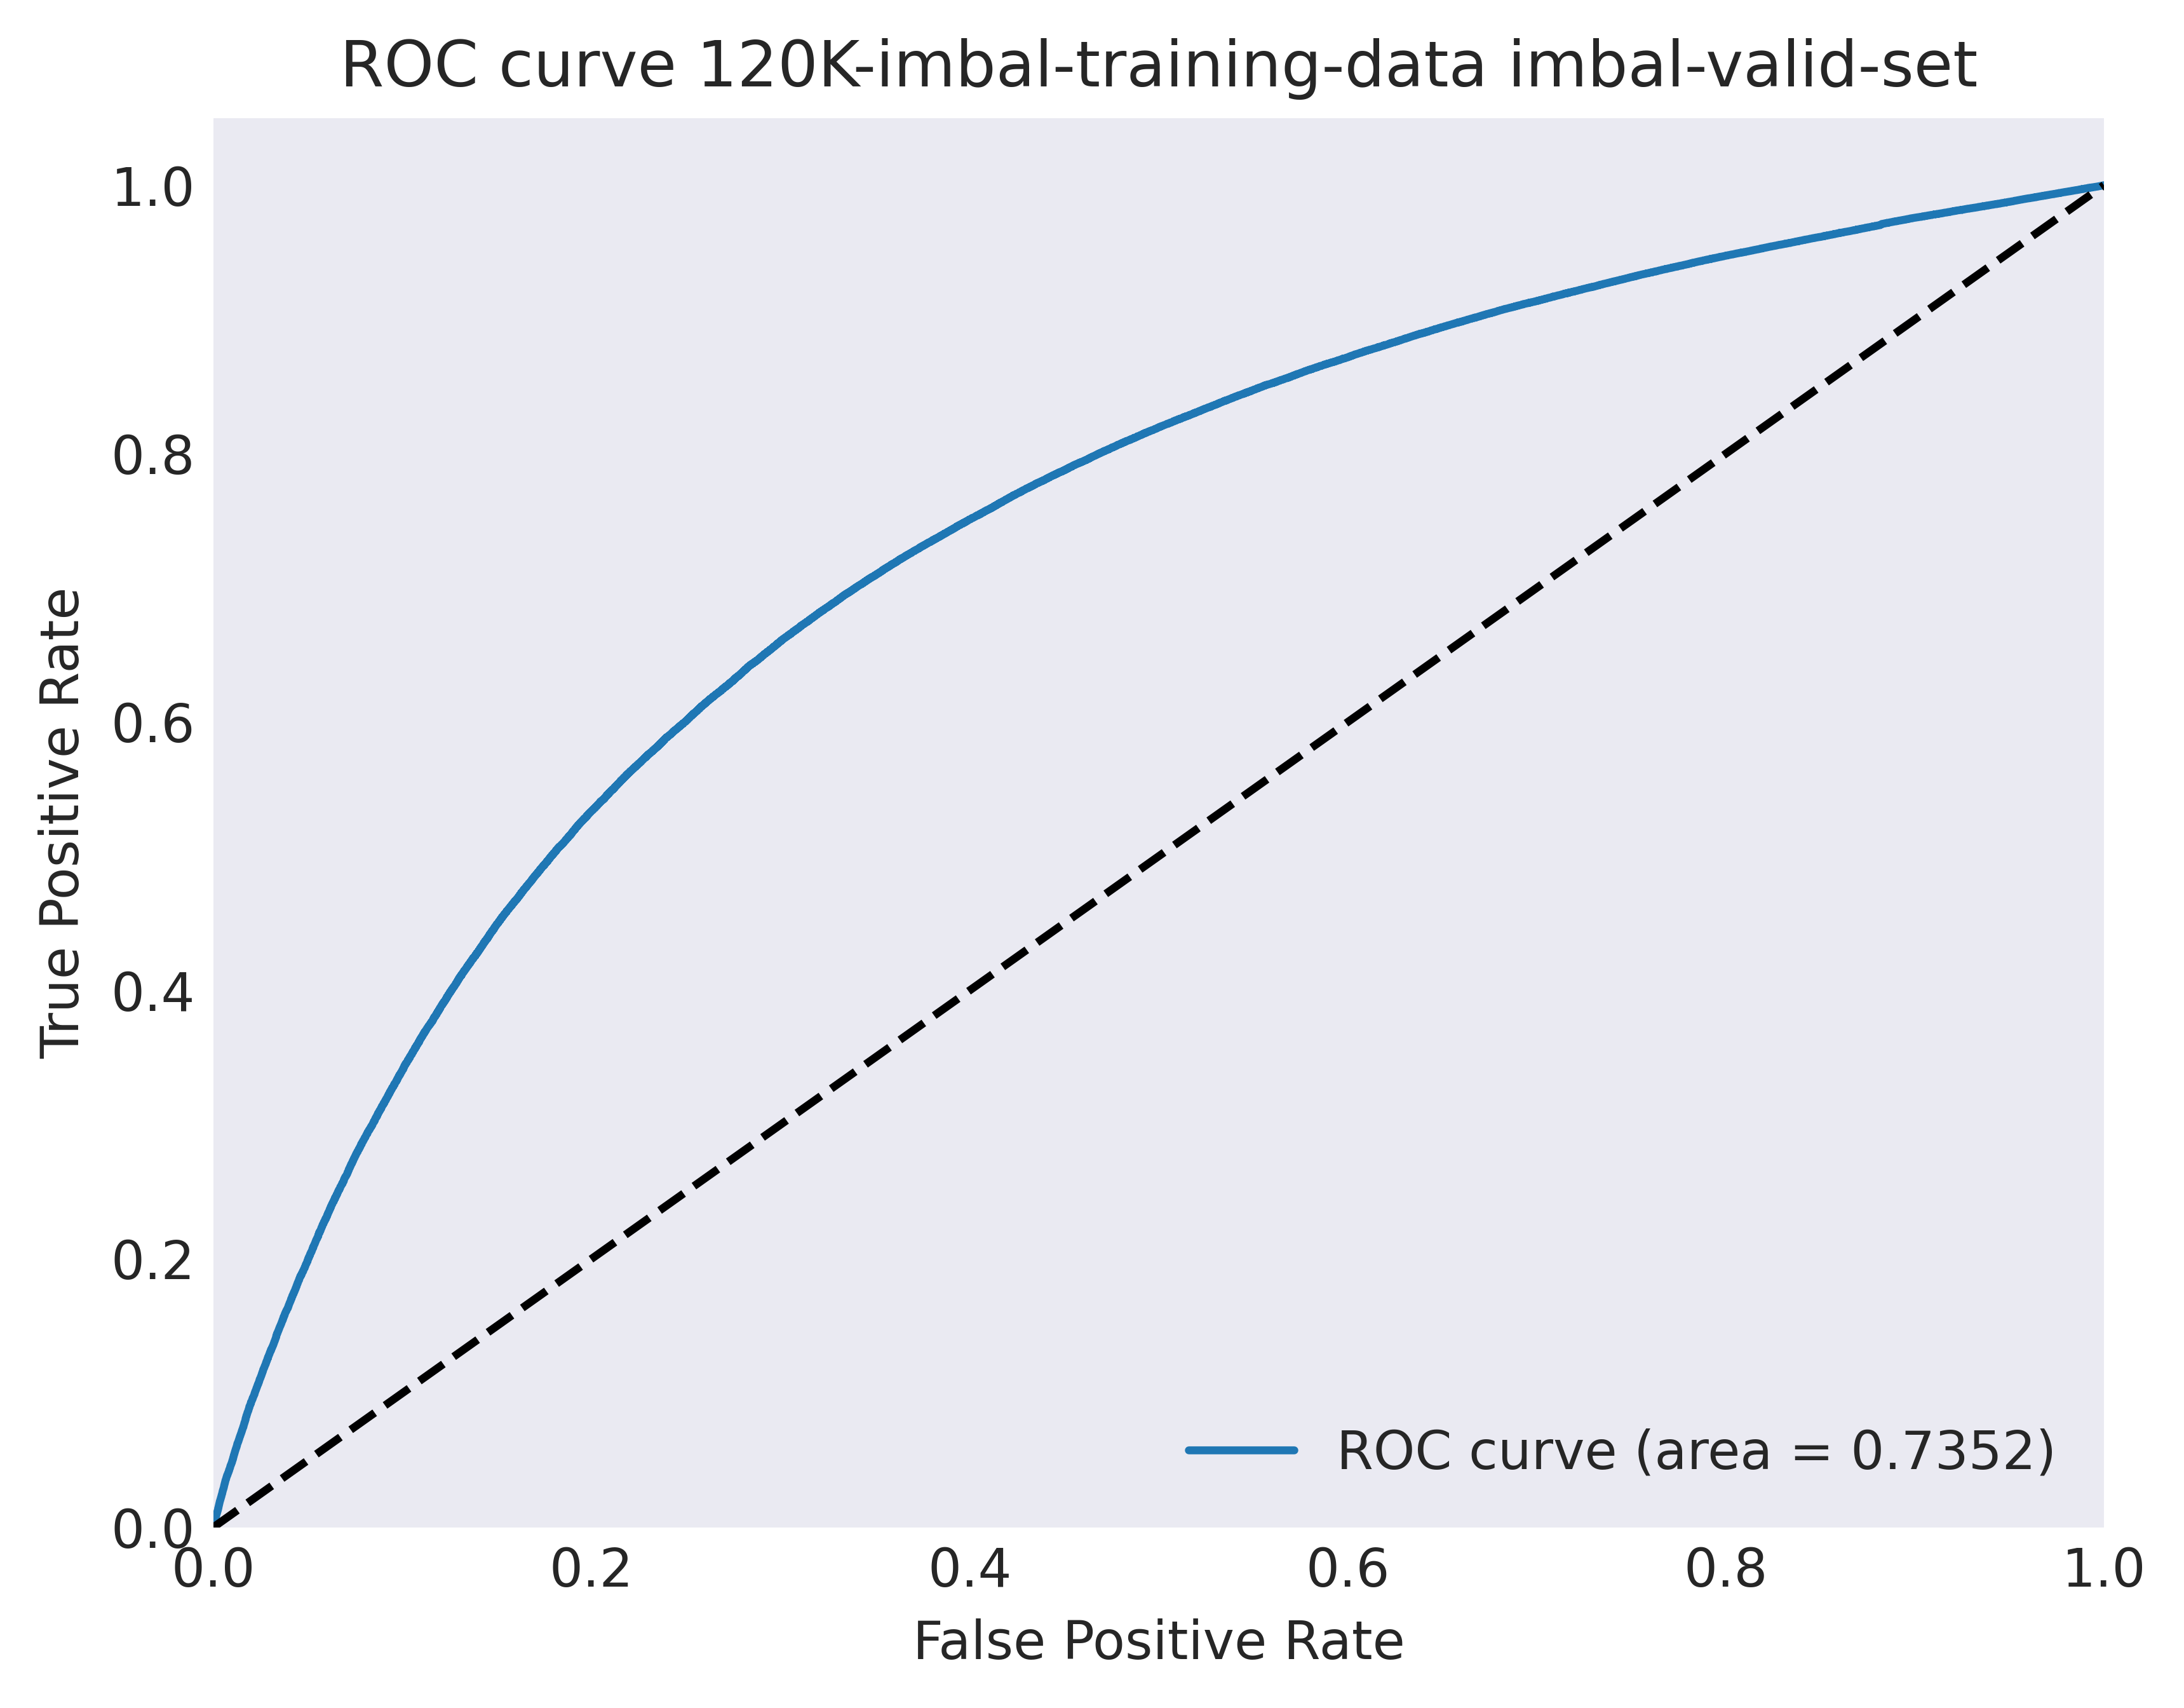

In [208]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'roc_curve_valid_imbal.png'),
    show=True
)

In [209]:
# add ROC area to report_dict
imbal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_imbal_valid, y_imbal_valid_pred_prob)

imbal_valid_report_df = evaluation_functions.create_classification_report_df(imbal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    imbal_valid_report_df.to_csv(Path.joinpath(eval_valid_imbal_folder, "{}_{}_valid_imbal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

Evluation end